In [ ]:
import os, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float

def matrix_to_tensor(matrix, device=device, dtype=dtype):
    tensor = torch.tensor(matrix, dtype=dtype).to(device)
    return tensor

In [ ]:
class OrnstienUhlenbeckNoise(object):
    def __init__(self, mu, dt=1e-2, theta=0.15, sigma=0.2, x0=None):
        self.theta = theta
        self.sigma = sigma
        self.mu = mu
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.xprev + self.theta * (self.mu - self.xprev) * self.dt + \
        self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.xprev  = x

        return x

    def reset(self):
        self.xprev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

In [ ]:
class ReplayBuffer(object):
    def __init__(self, buffer_size, batch_size, input_dims, num_actions):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.buffer_count = 0
        self.states_memory = np.zeros((buffer_size, *input_dims))
        self.nextstates_memory = np.zeros((buffer_size, *input_dims))
        self.actions_memory = np.zeros((buffer_size, num_actions))
        self.rewards_memory = np.zeros((buffer_size))
        self.dones_memory = np.zeros((buffer_size))

    def store_transition(self, state, action, reward, state_, done):
        idx = self.buffer_count % self.buffer_size

        self.states_memory[idx] = state
        self.actions_memory[idx] = action
        self.rewards_memory[idx] = reward
        self.nextstates_memory[idx] = state_
        self.dones_memory[idx] = 1 - int(done)

        self.buffer_count += 1

    def sample_memory(self):
        max_mem = min(self.buffer_count, self.buffer_size)
        idxs = np.random.choice(max_mem, self.batch_size)

        states = self.states_memory[idxs]
        actions = self.actions_memory[idxs]
        rewards = self.rewards_memory[idxs]
        nextstates = self.nextstates_memory[idxs]
        dones = self.dones_memory[idxs]

        return states, actions, rewards, nextstates, dones

In [ ]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, num_actions, beta, name, batch_size=64,
                 chkpt_dir='drive/My Drive/ddpg/'):
        super(CriticNetwork, self).__init__()
        self.beta = beta
        self.input_dims = input_dims
        self.num_actions = num_actions
        self.batch_size = batch_size
        self.chkpt_dir = chkpt_dir
        self.model_file = self.chkpt_dir+name+'_llddpg'

        self.num_l1 = 400
        self.num_l2 = 300

        self.fc1 = nn.Linear(*self.input_dims, self.num_l1)
        f1 = 1. / np.sqrt(self.fc1.weight.data.size()[0])
        nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        self.bn1 = nn.LayerNorm(self.num_l1)

        self.fc2_val1 = nn.Linear(self.num_l1, self.num_l2)
        f2 = 1. / np.sqrt(self.fc2_val1.weight.data.size()[0])
        nn.init.uniform_(self.fc2_val1.weight.data, -f2, f2)
        self.bn2 = nn.LayerNorm(self.num_l2)

        self.fc2_val2 = nn.Linear(self.num_actions, self.num_l2)

        self.qval = nn.Linear(self.num_l2, 1)
        f3 = 0.003
        nn.init.uniform_(self.qval.weight.data, -f3, f3)
        nn.init.uniform_(self.qval.bias.data, -f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=self.beta)
        self.to(device)

    def forward(self, state, action):
        layer = self.fc1(state)
        layer = self.bn1(layer)
        layer = F.relu(layer)

        layer = self.fc2_val1(layer)
        value1 = self.bn2(layer)
        value2 = self.fc2_val2(action)

        sumval = F.relu(torch.add(value1, value2))
        qval = self.qval(sumval)

        return qval

    def save_model(self):
        print('... saving model ...')
        torch.save(self.state_dict(), self.model_file)

    def load_model(self):
        print('... loading model ...')
        print(self.model_file)
        if os.path.exists(self.model_file):
            self.load_state_dict(torch.load(self.model_file))

In [ ]:
class ActorNetwork(nn.Module):
    def __init__(self, input_dims, num_actions, alpha, action_bound, name,
                 batch_size=64, chkpt_dir='drive/My Drive/ddpg/'):
        super(ActorNetwork, self).__init__()
        self.alpha = alpha
        self.input_dims = input_dims
        self.num_actions = num_actions
        self.batch_size = batch_size
        self.chkpt_dir = chkpt_dir
        self.model_file = self.chkpt_dir+name+'_llddpg'
        self.action_bound = action_bound

        self.num_l1 = 400
        self.num_l2 = 300

        self.fc1 = nn.Linear(*self.input_dims, self.num_l1)
        f1 = 1. / np.sqrt(self.fc1.weight.data.size()[0])
        nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        self.bn1 = nn.LayerNorm(self.num_l1)

        self.fc2 = nn.Linear(self.num_l1, self.num_l2)
        f2 = 1. / np.sqrt(self.fc2.weight.data.size()[0])
        nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        self.bn2 = nn.LayerNorm(self.num_l2)

        self.mu = nn.Linear(self.num_l2, self.num_actions)
        f3 = 0.003
        nn.init.uniform_(self.mu.weight.data, -f3, f3)
        nn.init.uniform_(self.mu.bias.data, -f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=self.alpha)
        self.to(device)

    def forward(self, state):
        layer = self.fc1(state)
        layer = self.bn1(layer)
        layer = F.relu(layer)
        layer = self.fc2(layer)
        layer = self.bn2(layer)
        layer = F.relu(layer)
        layer = self.mu(layer)
        mu = torch.tanh(layer)

        return mu

    def save_model(self):
        print('... saving model ...')
        torch.save(self.state_dict(), self.model_file)

    def load_model(self):
        print('... loading model ...')
        print(self.model_file)
        if os.path.exists(self.model_file):
            self.load_state_dict(torch.load(self.model_file))

In [ ]:
class NetworkField(object):
    def __init__(self, env, input_dims, num_actions, batch_size=64,
                 alpha=0.00005, beta=0.0005, gamma=0.99, tau=0.001):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.tau = tau

        self.batch_size = batch_size

        self.critic_eval = CriticNetwork(input_dims, num_actions, beta,
                           'critic_eval')
        self.actor_eval = ActorNetwork(input_dims, num_actions, alpha,
                          env.action_space.high, 'actor_eval')

        self.critic_target = CriticNetwork(input_dims, num_actions, beta,
                            'critic_target')
        self.actor_target = ActorNetwork(input_dims, num_actions, alpha,
                          env.action_space.high, 'actor_target')

        self.noise = OrnstienUhlenbeckNoise(np.zeros(num_actions))
        self.replay_buffer = ReplayBuffer(1000000, batch_size, input_dims,
                                        num_actions)

        self.critic_target.load_state_dict(
                                dict(self.critic_eval.named_parameters()))
        self.actor_target.load_state_dict(
                                dict(self.actor_eval.named_parameters()))

    def choose_action(self, state):
        state = matrix_to_tensor(state[np.newaxis, :])
        self.actor_eval.eval()
        mu = self.actor_eval.forward(state) + matrix_to_tensor(self.noise())
        mu *= matrix_to_tensor(self.actor_eval.action_bound)
        self.actor_eval.train()

        return mu.cpu().detach().numpy()[0]

    def make_action(self, state):
        state = matrix_to_tensor(state[np.newaxis, :])
        self.actor_eval.eval()
        mu = self.actor_eval.forward(state)
        mu *= matrix_to_tensor(self.actor_eval.action_bound)

        return mu.cpu().detach().numpy()[0]

    def store_experience(self, state, action, reward, state_, done):
        self.replay_buffer.store_transition(state, action, reward, state_, done)

    def learn(self):
        if self.replay_buffer.buffer_count < self.batch_size:
            return False

        states, actions, rewards, nextstates, dones = \
                                self.replay_buffer.sample_memory()

        states = matrix_to_tensor(states)
        actions = matrix_to_tensor(actions)
        nextstates = matrix_to_tensor(nextstates)
        rewards = matrix_to_tensor(rewards)
        dones = matrix_to_tensor(dones)

        self.critic_target.eval()
        self.actor_target.eval()
        self.critic_eval.eval()

        nextactions = self.actor_target.forward(nextstates)
        nextqvals = self.critic_target.forward(nextstates, nextactions)
        qvals = self.critic_eval.forward(states, actions)

        yvals = []

        for i in range(self.batch_size):
            yvals.append(rewards[i] + self.gamma*nextqvals[i]*dones[i])

        yvals = matrix_to_tensor(yvals)
        yvals = yvals.view(self.batch_size, 1)

        #critic_loss: where we optimize critic_eval by calculating yvals
        self.critic_eval.train()
        self.critic_eval.optimizer.zero_grad()
        critic_loss = F.mse_loss(yvals, qvals)
        critic_loss.backward()
        self.critic_eval.optimizer.step()

        #actor_loss: where we optimize actor_eval by calculating mus
        self.critic_eval.eval()
        self.actor_eval.optimizer.zero_grad()
        mus = self.actor_eval.forward(states)
        self.actor_eval.train()
        actor_loss = torch.mean(-self.critic_eval(states, mus))
        actor_loss.backward()
        self.actor_eval.optimizer.step()

        self.soft_target_update()

    def soft_target_update(self, tau=None):
        if tau is None:
            tau = self.tau

        critic_target_weights = dict(self.critic_target.named_parameters())
        actor_target_weights = dict(self.actor_target.named_parameters())
        critic_eval_weights = dict(self.critic_eval.named_parameters())
        actor_eval_weights = dict(self.actor_eval.named_parameters())

        for name in critic_eval_weights:
            critic_target_weights[name] = tau*critic_eval_weights[name].clone() + \
            (1-tau)*critic_target_weights[name].clone()

        self.critic_target.load_state_dict(critic_target_weights)

        for name in actor_eval_weights:
            actor_target_weights[name] = tau*actor_eval_weights[name].clone() + \
            (1-tau)*actor_target_weights[name].clone()

        self.actor_target.load_state_dict(actor_target_weights)

    def save_field(self):
        self.critic_target.save_model()
        self.critic_eval.save_model()
        self.actor_target.save_model()
        self.actor_eval.save_model()

    def load_field(self):
        self.critic_target.load_model()
        self.critic_eval.load_model()
        self.actor_target.load_model()
        self.actor_eval.load_model()

In [ ]:
%%bash
pip install gym[box2d]
apt-get install -y xvfb python-opengl > /dev/null 2>&1
apt-get install x11-utils
pip install gym pyvirtualdisplay

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils
0 upgraded, 2 newly installed, 0 to remove and 25 not upgraded.
Need to get 209 kB of archives.
After this operation, 711 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Fetched 209 kB in 2s (110 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 147475 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 

In [ ]:
def load_models(network_field):
        if os.path.exists(network_field.actor_eval.model_file):
            network_field.load_field()

In [ ]:
def train_lunarlander_field(env, network_field):
    np.random.seed(0)

    num_episodes = 1000
    save_episodes = 25
    done = False
    score_hist = []
    score = 0

    for e in range(num_episodes):
        state = env.reset()
        done = False
        score = 0
        while not done:
            action = network_field.choose_action(state)
            state_, reward, done, _ = env.step(action)
            network_field.store_experience(state, action, reward, state_, done)
            network_field.learn()
            score += reward
            state = state_

        if e % save_episodes == 0:
            network_field.save_field()
        
        score_hist.append(score)
        running_avg = np.mean(score_hist[-100:])
        print('episode: ', e,
              ' score: %.2f' % score,
              ' running avg (last 100): %.3f' % running_avg)

In [ ]:
def test_lunarlander_field(env, network_field):

    num_episodes = 100
    done = False
    score_hist = []
    score = 0

    for e in range(num_episodes):
        state = env.reset()
        done = False
        score = 0
        frame = 0

        while not done:
            action = network_field.make_action(state)
            state_, reward, done, _ = env.step(action)
            score += reward
            state = state_
            frame += 1

        score_hist.append(score)
        running_avg = np.mean(score_hist)
        print('episode: ', e,
              ' score: %.2f' % score,
              ' running avg (last 100): %.3f' % running_avg,
              ' num frames: %d' % frame)

In [ ]:
import gym
import numpy as np

env = gym.make('LunarLanderContinuous-v2')

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
network_field = NetworkField(env=env, input_dims=[8],
                             num_actions=env.action_space.shape[0],
                             batch_size=64,
                             alpha=0.000025,
                             beta=0.00025)

In [ ]:
load_models(network_field)

... loading model ...
drive/My Drive/ddpg/critic_target_llddpg
... loading model ...
drive/My Drive/ddpg/critic_eval_llddpg
... loading model ...
drive/My Drive/ddpg/actor_target_llddpg
... loading model ...
drive/My Drive/ddpg/actor_eval_llddpg


In [ ]:
test_lunarlander_field(env=env, network_field=network_field)

episode:  0  score: 254.74  running avg (last 100): 254.735  num frames: 189
episode:  1  score: 280.78  running avg (last 100): 267.757  num frames: 288
episode:  2  score: 62.33  running avg (last 100): 199.283  num frames: 141
episode:  3  score: 261.34  running avg (last 100): 214.797  num frames: 180
episode:  4  score: 274.57  running avg (last 100): 226.752  num frames: 182
episode:  5  score: 253.20  running avg (last 100): 231.160  num frames: 337
episode:  6  score: 244.09  running avg (last 100): 233.007  num frames: 197
episode:  7  score: 205.87  running avg (last 100): 229.616  num frames: 270
episode:  8  score: 261.49  running avg (last 100): 233.157  num frames: 180
episode:  9  score: 232.75  running avg (last 100): 233.116  num frames: 190
episode:  10  score: 261.98  running avg (last 100): 235.740  num frames: 205
episode:  11  score: 254.11  running avg (last 100): 237.271  num frames: 328
episode:  12  score: 245.94  running avg (last 100): 237.938  num frames: 2

In [ ]:
train_lunarlander_field(env=env, network_field=network_field)

... saving model ...
... saving model ...
... saving model ...
... saving model ...
episode:  0  score: 255.14  running avg (last 100): 255.141
episode:  1  score: 264.28  running avg (last 100): 259.710
episode:  2  score: 279.75  running avg (last 100): 266.391
episode:  3  score: 223.94  running avg (last 100): 255.779
episode:  4  score: -106.40  running avg (last 100): 183.343
episode:  5  score: -359.06  running avg (last 100): 92.942
episode:  6  score: 189.20  running avg (last 100): 106.693
episode:  7  score: -220.02  running avg (last 100): 65.854
episode:  8  score: -68.26  running avg (last 100): 50.952
episode:  9  score: -573.05  running avg (last 100): -11.447
episode:  10  score: -96.66  running avg (last 100): -19.194


KeyboardInterrupt: ignored

In [ ]:
test_lunarlander_field(env=env, network_field=network_field)

episode:  0  score: 265.89  running avg (last 100): 265.887  num frames: 215
episode:  1  score: 255.94  running avg (last 100): 260.913  num frames: 374
episode:  2  score: 259.43  running avg (last 100): 260.417  num frames: 228
episode:  3  score: 237.90  running avg (last 100): 254.788  num frames: 962
episode:  4  score: -16.52  running avg (last 100): 200.527  num frames: 1000
episode:  5  score: -29.52  running avg (last 100): 162.186  num frames: 1000
episode:  6  score: 256.32  running avg (last 100): 175.633  num frames: 191
episode:  7  score: 278.96  running avg (last 100): 188.548  num frames: 208
episode:  8  score: 253.61  running avg (last 100): 195.777  num frames: 223
episode:  9  score: -39.93  running avg (last 100): 172.206  num frames: 1000
episode:  10  score: 277.88  running avg (last 100): 181.813  num frames: 238
episode:  11  score: 255.45  running avg (last 100): 187.949  num frames: 206
episode:  12  score: 1.37  running avg (last 100): 173.597  num frames:

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(600, 600))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '600x600x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '600x600x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

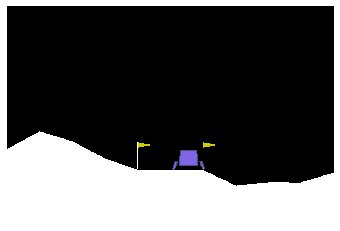

Score: 238.15
Num Frames: 185


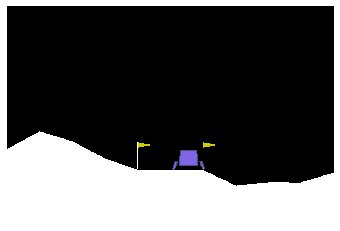

In [ ]:
def show_env_field(env, field, step=0, info=""):
    state = env.reset()
    score = 0
    done = False
    frame = 0
    while not done:
        plt.figure(3)
        plt.clf()
        action = field.make_action(state)
        state_, reward, done, _ = env.step(action)
        plt.imshow(env.render(mode='rgb_array'))
        plt.axis('off')

        display.clear_output(wait=True)
        display.display(plt.gcf())

        state = state_
        score += reward
        frame += 1
    
    print('Score: %.2f' % score)
    print('Num Frames: %d' % frame)

show_env_field(env, network_field)

In [ ]:
os.path.exists('drive/My Drive/ddpg/critic_target_ddpg')

True